In [43]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix

In [44]:
df = pd.read_csv('heart.csv')
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


Text(0.5, 1.0, 'Distribution of target class')

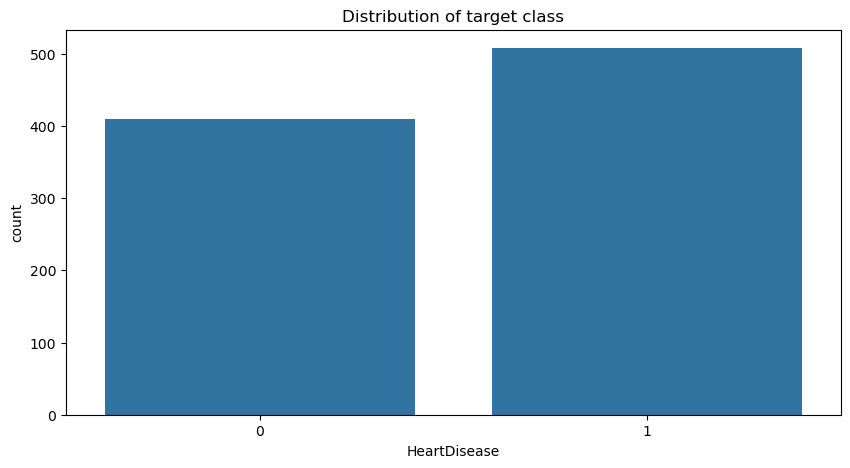

In [45]:
plt.figure(figsize=(10, 5))
sns.countplot(x='HeartDisease', data=df)
plt.title("Distribution of target class")

Text(0.5, 1.0, 'Correlation of numerical attributes with HeartDisease')

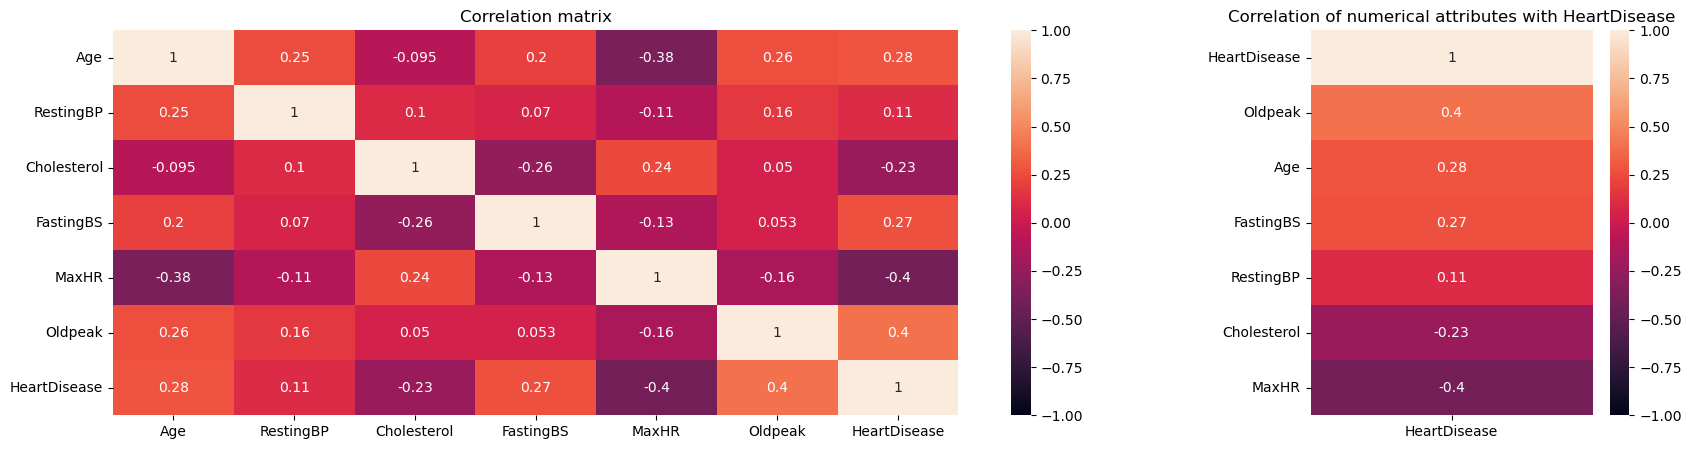

In [46]:
f, axs = plt.subplots(1, 2, figsize=(20, 5), width_ratios=[3, 1])

sns.heatmap(data=df.corr(method="pearson", numeric_only=True), vmin=-1, vmax=1, annot=True, ax=axs[0])
axs[0].set_title("Correlation matrix")

sns.heatmap(data=df.corr(method="pearson", numeric_only=True)[["HeartDisease"]].sort_values('HeartDisease', ascending=False), vmin=-1, vmax=1, annot=True, ax=axs[1])
axs[1].set_title("Correlation of numerical attributes with HeartDisease")

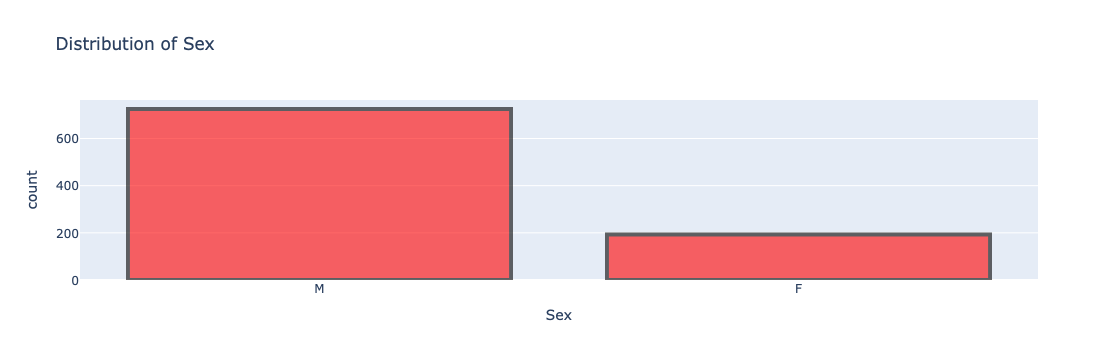

<Figure size 2000x1000 with 0 Axes>

In [47]:
plt.figure(figsize=(20, 10))
fig = px.histogram(data_frame=df, x="Sex", title="Distribution of Sex")
fig.update_traces(marker={"color": "red", "opacity": 0.6, "line": {"width": 4, "color": "black"}})
fig.show()

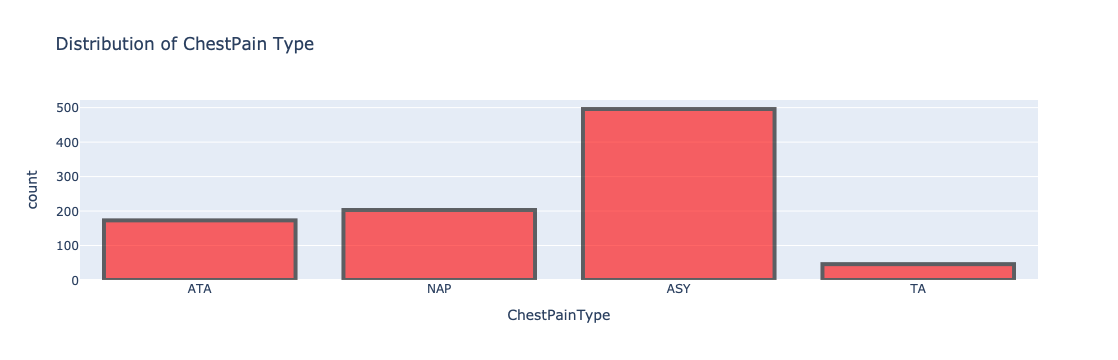

<Figure size 2000x1000 with 0 Axes>

In [48]:
plt.figure(figsize=(20, 10))
fig = px.histogram(data_frame=df, x="ChestPainType", title="Distribution of ChestPain Type")
fig.update_traces(marker={"color": "red", "opacity": 0.6, "line": {"width": 4, "color": "black"}})
fig.show()

In [50]:
median_cholesterol = df['Cholesterol'].median()
df['Cholesterol'] = df['Cholesterol'].replace(0, median_cholesterol)

def preprocessing(df, is_training=True, label_encoders=None):
    categorical_columns = ['Sex', 'ChestPainType', 
                           'RestingECG', 'ExerciseAngina', 'ST_Slope']
    
    if is_training:
        label_encoders = {}
        for col in categorical_columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
        
        X = df.drop(columns=['HeartDisease'])
        y = df['HeartDisease']
        return X, y, label_encoders
    else:
        for col in categorical_columns:
            if col in label_encoders:
                df[col] = label_encoders[col].transform(df[col])
        return df

X, y, label_encoders = preprocessing(df, is_training=True)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, 
                                                    random_state=42)

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    cm = confusion_matrix(y_test, y_pred)
    
    metrics = {
        "Model": model.__class__.__name__,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
    }
    
    return metrics

param_grids = {
    RandomForestClassifier(random_state=42): {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5, 10]
    },
    SVC(random_state=42, probability=True): {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    KNeighborsClassifier(): {
        'n_neighbors': [3, 5, 7, 10],
        'weights': ['uniform', 'distance']
    },
    DecisionTreeClassifier(random_state=42): {
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10]
    },
}

best_models = []
for model, params in param_grids.items():
    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_metrics = evaluate_model(best_model, X_train, y_train, X_test, y_test)
    best_models.append(best_metrics)

best_results_df = pd.DataFrame(best_models)

print("Best Model Performance Metrics:\n", best_results_df)

best_model_by_accuracy = best_results_df.loc[best_results_df['Accuracy'].idxmax()]
print("\nBest Model by Accuracy:\n", best_model_by_accuracy)

best_model_by_f1 = best_results_df.loc[best_results_df['F1 Score'].idxmax()]
print("\nBest Model by F1 Score:\n", best_model_by_f1)

best_model_by_precision = best_results_df.loc[best_results_df['Precision'].idxmax()]
print("\nBest Model by Precision:\n", best_model_by_precision)

best_model_by_recall = best_results_df.loc[best_results_df['Recall'].idxmax()]
print("\nBest Model by Recall:\n", best_model_by_recall)

Best Model Performance Metrics:
                     Model   Accuracy   F1 Score  Precision     Recall
0  RandomForestClassifier  88.043478  89.423077  92.079208  86.915888
1                     SVC  84.782609  86.666667  88.349515  85.046729
2    KNeighborsClassifier  83.152174  85.024155  88.000000  82.242991
3  DecisionTreeClassifier  82.065217  84.057971  87.000000  81.308411

Best Model by Accuracy:
 Model        RandomForestClassifier
Accuracy                  88.043478
F1 Score                  89.423077
Precision                 92.079208
Recall                    86.915888
Name: 0, dtype: object

Best Model by F1 Score:
 Model        RandomForestClassifier
Accuracy                  88.043478
F1 Score                  89.423077
Precision                 92.079208
Recall                    86.915888
Name: 0, dtype: object

Best Model by Precision:
 Model        RandomForestClassifier
Accuracy                  88.043478
F1 Score                  89.423077
Precision               